In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *

In [4]:
import os
os.getcwd()
os.listdir()
path = r"/home/ubuntu/share/SET II/"
os.chdir(path)
os.getcwd()

'/home/ubuntu/share/SET II'

### Download Test and Train Dataset

In [5]:
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

In [29]:
df_test.head()

,pid,sentence1,sentence2
0,42827,How will I be intimated if I win cricket,How will I be intimated if I win
1,40952,When will I get cadhback,When i get refund
2,44755,share nearby atm,closest atms
3,18692,What does Repairs under warranty cover?,maintenance under warranty
4,75416,Who is liable to pay the TDS on property?,how to pay tds on property


In [6]:
df_train.head()

,pid,sentence1,sentence2,label
0,828,any offer running on flights,Any discounts available for purchase of tickets,0
1,31092,I want to get connected to your wifi,I want to talk to your next level,0
2,7192,send jokes daily,Please don't send jokes,0
3,625,Fanta has too much sugar,quantity of sugar in fanta,1
4,67935,set reminder birthday,schedule a reminder exercise,0


# Logic and Approach

Problem statement is that we would like to classify if the 2 texts are similar or not. Since the training data is already labels, this makes it a supervised learning classification problem. 

Approach:
The approach I am using is that I am concating both the sentences and making it as a single sentence. This is captured when we build a datablock using fastai. It concats the sentenses with a marker. 

Also, Fast ai takes care of the preprocessing like tokenization, numericalization internally when fastai is creating databunch. It may not be required to do tokenization seperately unless we need to perform things outside the perview of prepossing done by fastai

#### Model:
1. Language Model: learn the language using a pre-trained model(wiki) and add the chat sentences to it and create an updated language model. 

2. Classificaiton model: build a classification model based on the vocab used in language model

### CReate DataBunch for Lanugage Model

In [12]:
data_lm = TextLMDataBunch.from_csv(path,'train_set.csv',test='test_set.csv',valid_pct=0.1,label_cols='label',
                                   text_cols=['sentence1','sentence2'],bs=48)
data_lm.show_batch()

idx,text
0,"xxmaj what are the chances of xxup lpg leakage in the manifold xxmaj installation ? xxbos i want flight rate xxmaj set xxmaj flight xxmaj fare xxmaj alerts xxbos xxmaj price is very high xxmaj your xxmaj prices too high xxbos xxmaj can you remind me to wish anniversary xxmaj hey , can you remind me to wish someone xxmaj happy xxmaj birthday ? . xxbos i 've given you"
1,xxmaj do u have any promocode xxmaj any xxmaj offers on xxmaj movie xxmaj ticket xxbos i want to update nominee provide the documentation details to update nominee who is minor xxbos xxmaj total xxmaj secure plus eligibility criteria for total secure plus xxbos xxmaj bali xxmaj honeymoon xxmaj destinations i 'm interested in xxmaj romance in the xxmaj blues : xxmaj bali xxmaj honeymoon xxmaj package for 6 xxmaj
2,xxmaj birthday xxmaj reminder i would like to modify my xxmaj birthday reminder xxbos i want to book train ticket xxmaj book train xxbos xxmaj where to log out where to apply the lounge code xxbos xxmaj explain me the key features of xxmaj total xxmaj secure i want to know the key features of xxmaj total xxmaj secure xxbos xxmaj are there any discount or cashback offers any offer
3,"alert xxmaj flight alerts xxbos i want to know about personal loan information xxmaj no personal loan xxbos xxmaj send me the ticket on my mail xxmaj please email the tickets xxbos pay entry fee for contests xxmaj entry fees is refunded xxbos acting jobs available i wish to join your company , any jobs available xxbos i would like to book a flight ticket xxmaj want to book my"
4,me xxmaj flight xxmaj tickets i need flight xxbos xxmaj jokes tell me a joke xxbos xxmaj any offer for me i recharged my mobile using phonepe and i ca nt find any cashback xxbos set reminder drink water schedule a reminder xxbos give me a joke xxmaj send joke everyday xxbos xxmaj visa required xxmaj visa xxbos price is high xxmaj too high xxbos xxmaj still not received xxmaj


In [13]:
data_c = TextDataBunch.from_csv(path,'train_set.csv',valid_pct=0.2,test='test_set.csv',
                                  text_cols=['sentence1','sentence2'],label_cols='label',vocab=data_lm.train_ds.vocab)

data_c.show_batch()

text,target
xxbos xxmaj how safe is your cylinder and as a xxmaj customer what i should be checking while receiving a refill from your side ? \n xxmaj what are the check points need to check after receiving the refill ? \n xxmaj what are the checkpoints to ensure safe cylinder is received ? \r \n xxmaj what are the checkpoints to ensure cylinder is safe for use,0
xxbos i 'm interested in xxmaj best xxmaj selling xxmaj tour xxmaj package with xxmaj ferrari xxmaj world for 5 xxmaj days i 'm interested in xxmaj best xxmaj selling xxmaj dubai xxmaj tour xxmaj package xxmaj with xxmaj ferrari xxmaj world for 5 xxmaj days,1
xxbos xxmaj send me flight timings from xxmaj mumbai to xxmaj bangalore xxmaj please proceed with below flight from xxmaj delhi to xxmaj bangalore for 1 adult onward flight air dep 00 00 1 dec dep 00 00 1 dec,0
"xxbos xxmaj do i have to pay if i wish to close the account ? i have holdings in my xxmaj demat account , can i close my xxmaj demat account without transferring my shares ?",0
xxbos xxmaj can i order for the xxmaj new xxmaj supply through phone or any digital platform ? xxmaj do you sell adopters separately without the new supply ? xxmaj what is the procedure ?,0


#### Language Model

In [14]:

learn_lm = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3,model_dir="/tmp/model/")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


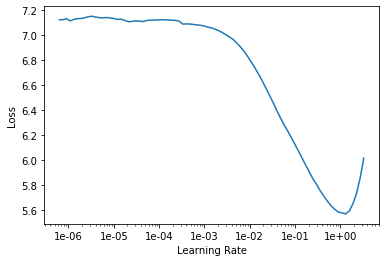

In [15]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [16]:
learn_lm.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.362492,3.024272,0.394477,00:24
1,2.929330,2.370002,0.489187,00:24
2,2.440741,2.280396,0.507242,00:24


In [17]:
learn_lm.save('fit-1')
learn_lm.save_encoder('fit_enc')

#### Classification Model

In [18]:
learn_lm.load('fit-1')
learn_lm = text_classifier_learner(data_c,AWD_LSTM,drop_mult=0.3,model_dir="/tmp/model/")
learn_lm.load_encoder('fit_enc');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


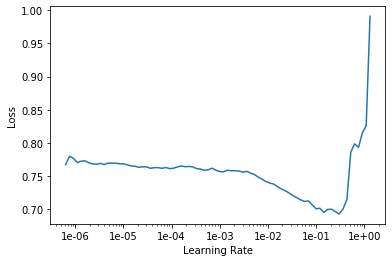

In [19]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [20]:
learn_lm.fit_one_cycle(5,1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.521760,0.497275,0.764773,00:12
1,0.515300,0.466155,0.787360,00:12
2,0.500183,0.441020,0.801050,00:12
3,0.458644,0.418210,0.807210,00:12
4,0.435062,0.416347,0.815651,00:12


### Model Finetune

We see the accuracy is about 81%. how ever, there may be a scope for further improvement. 

1. Unfreeze the whole model and fit it with learning rate of 1e-2. 
2. Explore a range of learning rates 
3. Add momentum. 

In [21]:
learn_lm.save('fit-2')

In [22]:
learn_lm.load('fit-2')
learn_lm.unfreeze()

In [23]:
learn_lm.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.451047,0.438308,0.809719,00:33
1,0.455807,0.467436,0.789870,00:34
2,0.469564,0.865392,0.798083,00:33
3,0.426757,0.529046,0.770705,00:32
4,0.405679,0.422386,0.830025,00:30
5,0.371442,0.458977,0.835045,00:33
6,0.340237,0.403504,0.838239,00:32
7,0.304783,0.360514,0.857175,00:33
8,0.263293,0.346593,0.872690,00:30
9,0.245839,0.353967,0.870865,00:32


In [52]:
learn_lm.save('fit2')

### Explore different learning Rates

In [53]:
learn_lm.fit_one_cycle(10,slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.267164,0.346034,0.872462,00:33
1,0.250357,0.331556,0.875200,00:32
2,0.230781,0.335160,0.871093,00:30
3,0.236245,0.374265,0.870180,00:32
4,0.216883,0.370150,0.874743,00:33
5,0.214033,0.356696,0.880903,00:31
6,0.199032,0.374291,0.878622,00:33
7,0.201543,0.346317,0.882957,00:33
8,0.185988,0.357628,0.881816,00:31
9,0.177144,0.373019,0.880903,00:32


In [57]:
learn_lm.save('fit3')

In [67]:
learn_lm.load('fit3')

learn_lm.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.192599,0.359161,0.880447,00:32
1,0.189693,0.516360,0.882501,00:30
2,0.208902,0.320765,0.886607,00:34
3,0.187156,0.351455,0.880675,00:32
4,0.178139,0.363473,0.880447,00:33
5,0.166322,0.367576,0.892539,00:33
6,0.159663,0.355840,0.888889,00:33
7,0.151604,0.380295,0.883641,00:30
8,0.144765,0.370406,0.890714,00:34
9,0.140453,0.382674,0.892311,00:30


### Observation
IF you observere we are getting an accuracy of 89% with the train loss of .14 and valid loss of 0.38

### REsults - 

1. Predictions for test data provided and save it as csv (pid and predicted labels)
2. Confusion matrix
3. F1 score calculated based on validation data set

In [27]:
data_c.test_ds

LabelList (2435 items)
x: TextList
xxbos xxmaj how will i be xxunk if i win cricket xxmaj how will i be xxunk if i win,xxbos xxmaj when will i get cadhback xxmaj when i get refund,xxbos share nearby atm closest atms,xxbos xxmaj what does xxmaj repairs under warranty cover ? maintenance under warranty,xxbos xxmaj who is liable to pay the xxup tds on property ? how to pay tds on property
y: EmptyLabelList
,,,,
Path: /home/ubuntu/share/SET II

### Predictions for Test Data

In [68]:
preds, y = learn_lm.get_preds(DatasetType.Test,ordered=True)

In [70]:
prediction = np.argmax(preds,axis=1).numpy()
print(prediction.shape)
prediction[0:10]


(2435,)


array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1])

In [71]:
df_results = pd.DataFrame()
df_results['pid'] = df_test['pid']
df_results['label'] = prediction

In [72]:
df_results.head()

,pid,label
0,42827,0
1,40952,0
2,44755,1
3,18692,0
4,75416,1


In [75]:
# upload file into upload folder
path_upload = r'/home/ubuntu/upload/'
os.listdir(path_upload)
os.chdir(path_upload)
df_results.to_csv('vidhyashankarVenkatesan_F03822_problem2.csv',header=True,index=False)

### Confusion Matrix

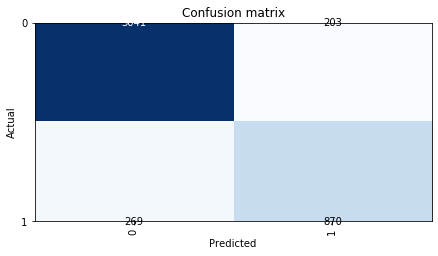

In [77]:
txt_ci = TextClassificationInterpretation.from_learner(learn_lm)
txt_ci.plot_confusion_matrix()

In [40]:
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
xxbos bank account balance link a bank account,1,0,7.29,0.00
"xxbos speaker xxmaj hi , i want to know the price of xxmaj touchlight xxmaj speaker .",1,0,6.95,0.00
xxbos xxmaj what are the charges for getting a new connection new connection,1,0,6.72,0.00
xxbos xxmaj ipl match result xxmaj who won the ipl match today,0,0,6.48,1.00
xxbos i want discount on flight tickets any cashback on flight booking,1,0,6.29,0.00


### F1 Score

In [73]:
preds, targets = learn_lm.get_preds()
predictions = np.argmax(preds,axis=1)

In [74]:
from sklearn.metrics import f1_score

y_true = (targets.numpy())
y_pred = predictions.numpy()

f1_score(y_true,y_pred,average='binary')

0.7866184448462928